In [1]:
CONFIG_PATH = '../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

In [2]:
# Load config
import json
import numpy as np
from pathlib import Path

### Подготавливаем визуализацию

In [14]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes

/alpha/projects/wastie/code/kondrashov/delta/notes


/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [15]:
# Create temporary directory for predictions
pred_labels_dir = Path('runs/segment/predict/labels')
pred_images_dir = Path('runs/segment/predict')

In [16]:
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

In [17]:
from matplotlib import pyplot as plt
import numpy as np

In [18]:
def group_len(g, border=True):
    return len([1 for m in g if border or not m['is_border']])
def group_matches(g, border=True):
    return sum(m['is_matched'] for m in g if border or not m['is_border'])
def calculate_integrated_precision(pred_groups, int_thr, border=True):
    matches = len([1 for g in pred_groups if group_matches(g, border) > 0 and group_len(g, border) >= int_thr])
    total = len([1 for g in pred_groups if group_len(g, border) >= int_thr])
    return matches / total

def calculate_integrated_recall(gt_groups, int_thr, border=True):
    matches = len([1 for g in gt_groups if group_matches(g, border) >= int_thr])
    total = len(gt_groups)
    return matches / total

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

def plot_match_probability(groupset, title):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])

    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)

    # Create bins and calculate probabilities
    bins = np.linspace(area_shares.min(), area_shares.max(), 16)
    bin_indices = np.digitize(area_shares, bins) - 1
    probabilities = []
    bin_centers = []

    for i in range(len(bins)-1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            prob = np.mean(is_matched[mask])
            probabilities.append(prob)
            bin_centers.append((bins[i] + bins[i+1]) / 2)

    # Apply Gaussian smoothing
    probabilities = np.array(probabilities)
    smoothed_probabilities = gaussian_filter(probabilities, sigma=2)

    # Plot probability distribution
    plt.plot(bin_centers, probabilities, 'o', alpha=0.3, label='Raw data')
    plt.plot(bin_centers, smoothed_probabilities, '-', label='Smoothed')
    plt.ylim(0, 1)
    plt.xlabel('Area Share')
    plt.ylabel('Probability of Match')
    plt.title(f'Probability of Match vs Area Share - {title}')
    plt.grid(True)
    plt.legend()


In [20]:
def plot_area_distribution(gt_groups, pred_groups, config):
    # Plot area distribution histograms
    plt.figure(figsize=(15, 6))

    # Ground Truth histogram
    plt.subplot(1, 2, 1)
    gt_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
                for group in gt_groups 
                for instance in group]
    plt.hist(gt_areas, bins=50, alpha=0.7)
    plt.xlabel('Area Share')
    plt.ylabel('Count')
    plt.title('Area Distribution - Ground Truth')
    plt.grid(True)

    # Predictions histogram
    plt.subplot(1, 2, 2)
    pred_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
                for group in pred_groups 
                for instance in group]
    plt.hist(pred_areas, bins=50, alpha=0.7)
    plt.xlabel('Area Share')
    plt.ylabel('Count')
    plt.title('Area Distribution - Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [21]:
from scipy import stats

def get_correlation_data(groupset):
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    return np.array(area_shares), np.array(is_matched)

def calculate_pcorr(gt_groups, pred_groups):
    # Get data for GT and Pred
    gt_areas, gt_matched = get_correlation_data(gt_groups)
    pred_areas, pred_matched = get_correlation_data(pred_groups)

    # Combine data for total
    total_areas = np.concatenate([gt_areas, pred_areas])
    total_matched = np.concatenate([gt_matched, pred_matched])

    # Calculate correlations and p-values
    gt_corr, gt_pval = stats.pearsonr(gt_areas, gt_matched)
    pred_corr, pred_pval = stats.pearsonr(pred_areas, pred_matched)
    total_corr, total_pval = stats.pearsonr(total_areas, total_matched)

    # Print results in a formatted table
    print(f"{'Dataset':<10} {'Correlation':>12} {'P-value':>12}")
    print("-" * 34)
    print(f"{'GT':<10} {gt_corr:>12.4f} {gt_pval:>12.4e}")
    print(f"{'Pred':<10} {pred_corr:>12.4f} {pred_pval:>12.4e}")
    print(f"{'Total':<10} {total_corr:>12.4f} {total_pval:>12.4e}")

In [22]:
def get_match_probability(groupset, a, b):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    
    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)
    
    # Find objects within the specified range
    mask = (area_shares >= a) & (area_shares <= b)
    
    # Calculate probability if there are objects in the range
    if np.sum(mask) > 0:
        probability = np.mean(is_matched[mask])
        return probability
    else:
        return None

## Плотный тест

In [23]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes

/alpha/projects/wastie/code/kondrashov/delta/notes


/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [24]:
import pickle
with open('gt_test_dense.pkl', 'rb') as f:
    gt_groups = pickle.load(f)
with open('pred_test_dense.pkl', 'rb') as f:
    pred_groups = pickle.load(f)

Median group size: 18


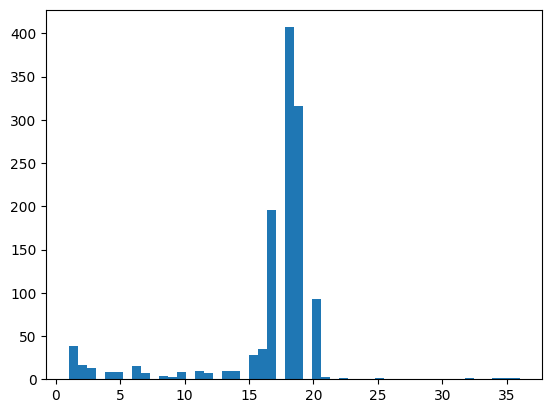

In [25]:
plt.hist([len(g) for g in gt_groups], bins=50)
median_length = int(np.median([len(g) for g in gt_groups]))
print(f"Median group size: {median_length}")

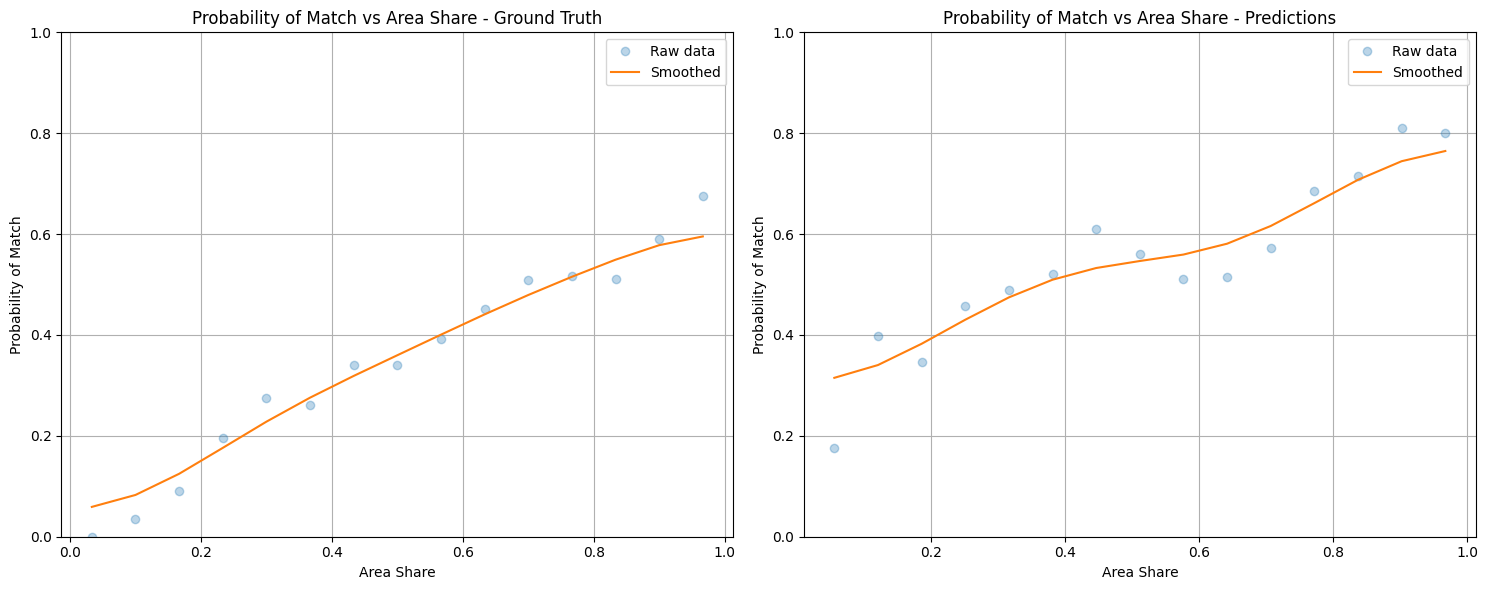

In [26]:
# Create subplots
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_match_probability(gt_groups, 'Ground Truth')
plt.subplot(1, 2, 2)
plot_match_probability(pred_groups, 'Predictions')
plt.tight_layout()
plt.show()

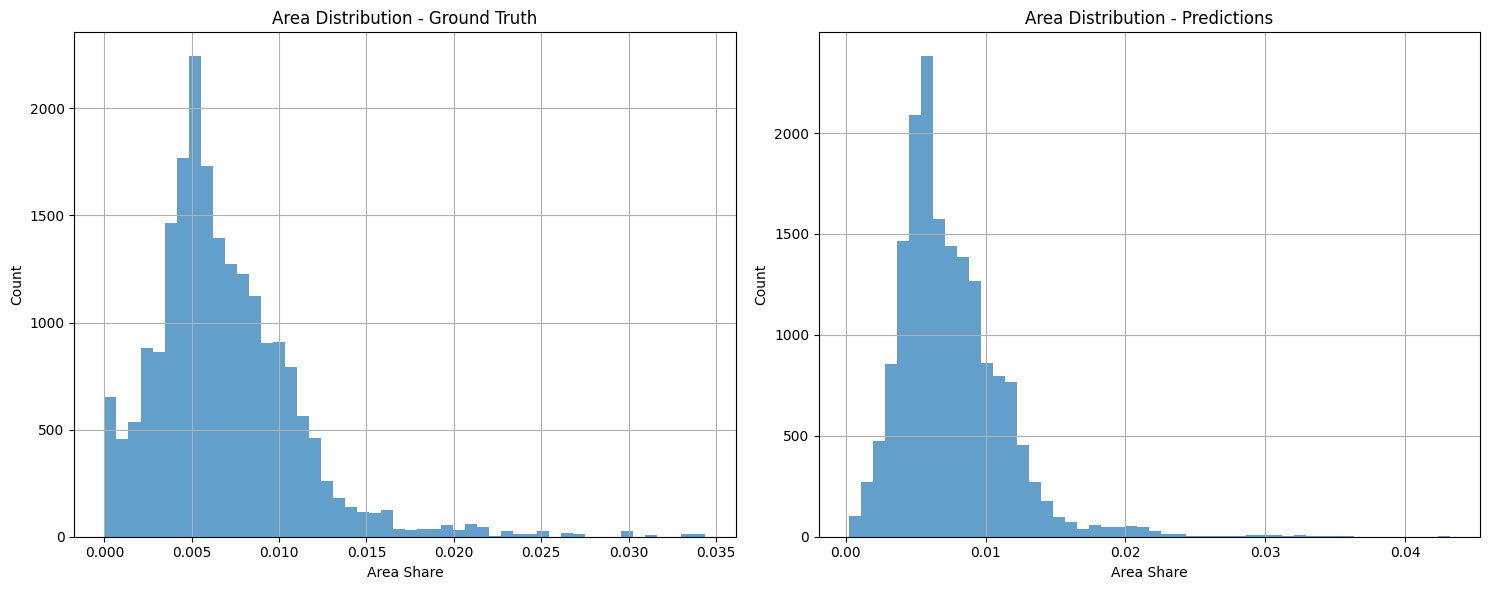

In [27]:
plot_area_distribution(gt_groups, pred_groups, config)

In [28]:
calculate_pcorr(gt_groups, pred_groups)

Dataset     Correlation      P-value
----------------------------------
GT               0.3326   0.0000e+00
Pred             0.1767  9.1074e-121
Total            0.2623   0.0000e+00


In [29]:
print("GT match probability:  ", float(get_match_probability(gt_groups, 0.0, 1.0)))
print("Pred match probability:", float(get_match_probability(pred_groups, 0.0, 1.0)))

GT match probability:   0.5959000145046657
Pred match probability: 0.7171652628521639


#### Все объекты

In [30]:
print("Per-mask precision:", (bpm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g]).mean()))
print("Per-obj precision:", (bpo_p := np.array([max(float(m['is_matched']) for m in g) for g in pred_groups]).mean()))

Per-mask precision: 0.7171652628521639
Per-obj precision: 0.6856788592684439


In [31]:
print("Per-mask recall:", (bpm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g]).mean()))
print("Per-obj recall:", (bpo_r := np.array([max(float(m['is_matched']) for m in g) for g in gt_groups]).mean()))

Per-mask recall: 0.5959000145046657
Per-obj recall: 0.8759065269943593


In [32]:
print("Per-mask F1:", bpm_p * bpm_r / (bpm_p + bpm_r) * 2)
print("Per-obj F1:", bpo_p * bpo_r / (bpo_p + bpo_r) * 2)

Per-mask F1: 0.6509330463693478
Per-obj F1: 0.7692062099692343


#### Без краевых объектов

In [33]:
print("Per-mask precision:", (pm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g if not m['is_border']]).mean()))
print("Per-obj precision:", (po_p := np.array([max(float(m['is_matched']) for m in g if not m['is_border']) for g in pred_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask precision: 0.7325523606673766
Per-obj precision: 0.7270194986072424


In [34]:
print("Per-mask recall:", (pm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g if not m['is_border']]).mean()))
print("Per-obj recall:", (po_r := np.array([max([float(m['is_matched']) for m in g if not m['is_border']] + [0]) for g in gt_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask recall: 0.6720918168849696
Per-obj recall: 0.8772226926333616


In [35]:
print("Per-mask F1:", pm_p * pm_r / (pm_p + pm_r) * 2)
print("Per-obj F1:", po_p * po_r / (po_p + po_r) * 2)

Per-mask F1: 0.7010208776179015
Per-obj F1: 0.7950894268302544


#### Доля ошибок классификации


In [36]:
print("GT per-mask ratio:", np.array([float(m['is_mask_matched']) for g in gt_groups for m in g if not m['is_matched']]).mean())
print("GT per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in gt_groups if max(float(m['is_matched']) for m in g) == False]).mean())

GT per-mask ratio: 0.0034697296003828666
GT per-obj ratio: 0.01948051948051948


In [37]:
print("Pred per-mask ratio:", np.array([float(m['is_mask_matched']) for g in pred_groups for m in g if not m['is_matched']]).mean())
print("Pred per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in pred_groups if max(float(m['is_matched']) for m in g) == False]).mean())

Pred per-mask ratio: 0.006777572396796057
Pred per-obj ratio: 0.005917159763313609


### Гипотеза о зависимости обрезанности и качества распознавания

In [38]:
gt_is_matched = []
gt_is_border = []
pred_is_matched = []
pred_is_border = []

for group in gt_groups:
    for obj in group:
        gt_is_matched.append(obj['is_matched'])
        gt_is_border.append(obj['is_border'])
        
for group in pred_groups:
    for obj in group:
        pred_is_matched.append(obj['is_matched'])
        pred_is_border.append(obj['is_border'])

is_matched = {"Pred": pred_is_matched, "GT": gt_is_matched, 'Total': pred_is_matched + gt_is_matched}
is_border = {"Pred": pred_is_border, "GT": gt_is_border, 'Total': pred_is_border + gt_is_border}

In [39]:
from scipy.stats import spearmanr

print("| Sample | Spearman correlation | p-value               |")
print("|--------|----------------------|-----------------------|")
for sample in ['GT', 'Pred', 'Total']:
    corr, p_value = spearmanr(is_border[sample], is_matched[sample])
    print(f"| {sample:>6} | {corr:>20.6f} | {p_value:>21} |")

| Sample | Spearman correlation | p-value               |
|--------|----------------------|-----------------------|
|     GT |            -0.265836 |                   0.0 |
|   Pred |            -0.072475 |  1.71595250874097e-21 |
|  Total |            -0.196581 |                   0.0 |


### Количество объектов, предсказанных только по краевым объектам

In [40]:
def get_border_only_matched(groups):
    border_only_matched = []
    border_only_matched_ids = []
    for i, group in enumerate(groups):
        border_matched = False
        non_border_matched = False
        non_border_found = False
        for obj in group:
            if obj['is_matched']:
                if obj['is_border']:
                    border_matched = True
                else:
                    non_border_matched = True
            if not obj['is_border']:
                non_border_found = True
        if border_matched and not non_border_matched and non_border_found:
            border_only_matched.append(group)
            border_only_matched_ids.append(i)
    return border_only_matched, border_only_matched_ids

In [41]:
gt_border_only, gt_border_ids = get_border_only_matched(gt_groups)
pred_border_only, pred_border_ids = get_border_only_matched(pred_groups)

In [42]:
print("GT:", len(gt_border_only), "elements", "out of", len(gt_groups), f"({len(gt_border_only) / len(gt_groups) * 100:.2f}%)")
print("Pred:", len(pred_border_only), "elements", "out of", len(pred_groups), f"({len(pred_border_only) / len(pred_groups) * 100:.2f}%)")

GT: 37 elements out of 1241 (2.98%)
Pred: 38 elements out of 1613 (2.36%)


### Пороговая интеграция

In [43]:
def find_best_int_thr(border : bool):
    thresholds = range(1, median_length + 1)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        precision = calculate_integrated_precision(pred_groups, threshold, border)
        recall = calculate_integrated_recall(gt_groups, threshold, border)
        f1 = 2 * (precision * recall) / (precision + recall)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold (Border: {border})')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

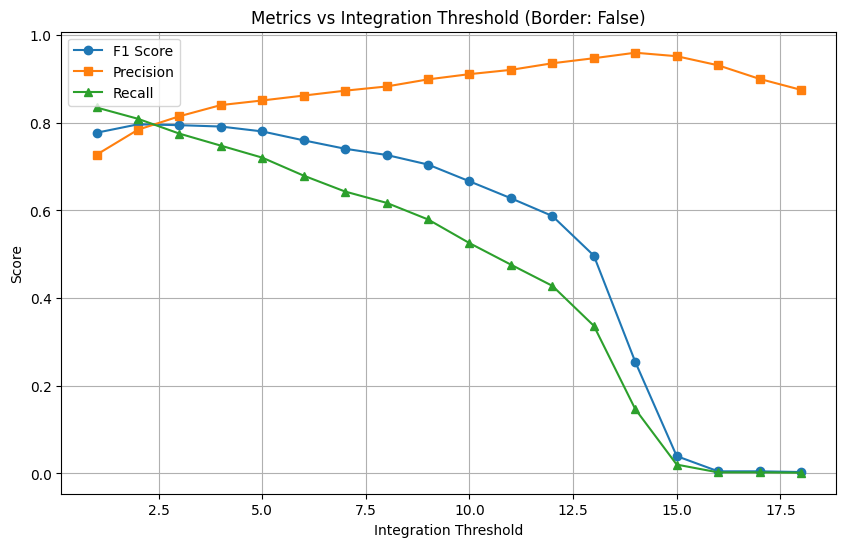

Max F1: 0.796 at threshold 2


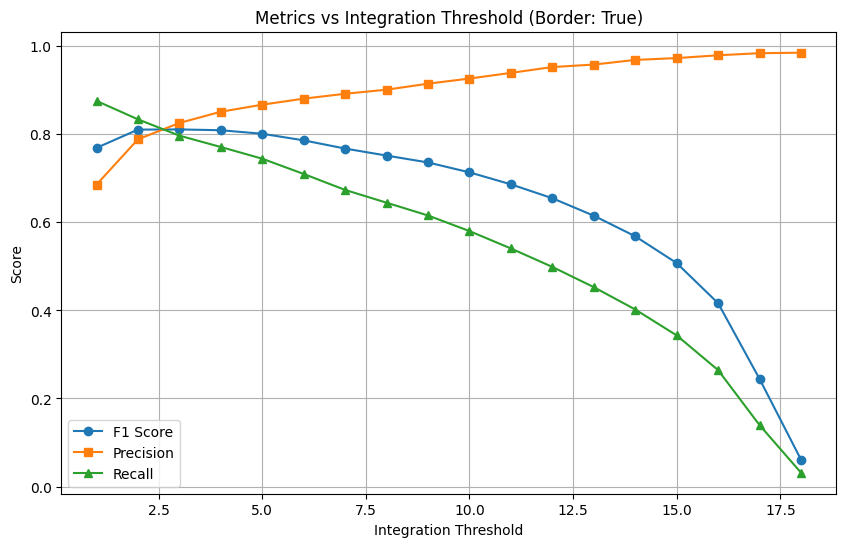

Max F1: 0.811 at threshold 3


In [44]:
find_best_int_thr(border=False)
find_best_int_thr(border=True)

## Реальная пороговая интеграция

In [45]:
import sys
sys.path.append('../utils')
sys.path.append('..')

from utils.integrate.make_piano import make_piano
from utils.integrate.utils import create_txt_for_empty

In [57]:
MODEL_VERSION = 'default'
DATASET_PATH = Path('/alpha/projects/wastie/code/kondrashov/delta/data/sparse_test')

In [59]:
import shutil

def find_best_conf(model, config):
    # Run validation to get best confidence threshold
    val_results = model.val(data=config['data'], split=SPLIT, device='cuda:1')

    best_f1_idx = np.argmax(val_results.seg.curves_results[1][1].mean(axis=0))
    best_f1 = val_results.seg.curves_results[1][1][..., best_f1_idx].mean()
    best_conf = val_results.seg.curves_results[1][0][best_f1_idx]
    print(f"Best F1: {best_f1:.4f} at confidence {best_conf:.4f}")
    return best_conf

def get_predictions(model, dataset_path, conf):
    PREDICT_DIR = Path('runs/segment/predict')
    # Load labels
    dataset_path = Path(dataset_path)
    
    shutil.rmtree(PREDICT_DIR, ignore_errors=True)
    # Run YOLO validation to get the best confidence score

    # Run prediction with best confidence
    for pred in model.predict(
        source=str(dataset_path / 'imgs'),
        conf=conf,
        save_txt=True,
        device='cuda:0',
        save=True,
        stream=True,
        imgsz=800
    ):
        pass
    
    return PREDICT_DIR / 'labels'

In [60]:
from ultralytics import YOLO
model = YOLO(config['models'][MODEL_VERSION])

conf = find_best_conf(model, config)
pred_dir =  get_predictions(model, DATASET_PATH, conf)

# Fill empty labels
create_txt_for_empty(DATASET_PATH / 'imgs', pred_dir)

Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:1 (NVIDIA A100 80GB PCIe, 81154MiB)
YOLOv8m-seg summary (fused): 263 layers, 24,586,614 parameters, 0 gradients, 98.7 GFLOPs


val: Scanning /alpha/projects/wastie/datasets/25_12_2_classes_fpfn_update_v2/test/labels.cache... 731 images, 150 backgrounds, 0 corrupt: 100%|██████████| 731/731 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


                   all        731       4144       0.91      0.889      0.953      0.848       0.91       0.89      0.952      0.799
                   bot        540       3093      0.899      0.882      0.951      0.845      0.901      0.884       0.95      0.794
                  alum        428       1051       0.92      0.896      0.956      0.851      0.919      0.895      0.953      0.805
Speed: 1.0ms preprocess, 6.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/val6
Best F1: 0.9018 at confidence 0.3854

image 1/3814 /alpha/projects/wastie/code/kondrashov/delta/data/sparse_test/imgs/tula_sep_0002_2024_07_22_18_00_00_000.jpg: 800x800 1 bot, 6.6ms
image 2/3814 /alpha/projects/wastie/code/kondrashov/delta/data/sparse_test/imgs/tula_sep_0002_2024_07_22_18_00_00_200.jpg: 800x800 1 bot, 7.0ms
image 3/3814 /alpha/projects/wastie/code/kondrashov/delta/data/sparse_test/imgs/tula_sep_0002_2024_07_22_18_00_00_400.jpg: 800x800 1 bot, 6.9ms
image 4/3814 /

In [ ]:
import torch
make_piano(
    labels=DATASET_PATH / 'gt_interp',
    speed=DATASET_PATH / 'speed.json',
    integration_thresh=0,
    save_to=DATASET_PATH / 'piano.csv',
    save_markup_to=DATASET_PATH / 'markup.txt',
    image_size=800,
    include_bound_masks=True,
    device=torch.device('cuda:0')
)

A piano was successfully saved to /alpha/projects/wastie/code/kondrashov/delta/data/sparse_test/piano.csv


Merging masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3814/3814 [01:08<00:00, 55.78it/s]


Markup was successfully saved to /alpha/projects/wastie/code/kondrashov/delta/data/sparse_test/markup.txt


In [ ]:
from utils.integrate.metrics import compute_metrics
metrics = compute_metrics(
    DATASET_PATH / 'piano.csv',
    Path('pred.csv'),
    DATASET_PATH / 'markup.txt',
    Path('pred.txt'),
    image_size=800,
    verbose=True
)


In [ ]:
from utils.integrate.metrics import compute_metrics
metrics = compute_metrics(
    DATASET_PATH / 'piano.csv',
    Path('pred.csv'),
    DATASET_PATH / 'markup.txt',
    Path('pred.txt'),
    image_size=800,
    verbose=True
)


Computing piano metrics...
Computing mask metrics...
[np.float32(457.4875), np.float32(516.77747), np.float32(580.9975), np.float32(1364.1375), np.float32(1394.2825), np.float32(1434.4775), np.float32(1464.6226), np.float32(1495.7675), np.float32(1517.8625), np.float32(1536.9625), np.float32(2232.2776), np.float32(2334.7576), np.float32(2371.9524), np.float32(2518.5874), np.float32(2575.9375), np.float32(2750.2974), np.float32(2779.4424), np.float32(2835.7324), np.float32(2872.9275), np.float32(3054.2175), np.float32(3083.3625), np.float32(3112.5076), np.float32(3149.7026), np.float32(3209.9924), np.float32(3440.1575), np.float32(3478.3528), np.float32(3507.4976), np.float32(3546.6926), np.float32(3570.7876), np.float32(3590.8872), np.float32(4517.0977), np.float32(4545.2427), np.float32(4596.4824), np.float32(4646.7227), np.float32(4659.7676), np.float32(4676.8677), np.float32(4701.4727), np.float32(4718.5723), np.float32(4743.7227), np.float32(5413.7974), np.float32(5415.9775), np.fl

Masks processed: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3511/3511 [00:23<00:00, 152.47it/s]

Metrics:
{'piano': {'iou': np.float64(0.8481192455833144), 'precision': np.float64(0.9026349396797481), 'recall': np.float64(0.9335221287122853), 'f1': np.float64(0.9178187474754921)}, 'markup': {'precision': np.float64(0.23440615209342067), 'recall': np.float64(0.2124031007751938)}}


In [71]:
import yaml

print("Integrated metrics")

metrics = {x: {k:float(v) for k, v in y.items()} for x,y in metrics.items()}
dict_str = yaml.dump(metrics, indent=4)
print(dict_str)

Integrated metrics
markup:
    precision: 0.23440615209342067
    recall: 0.2124031007751938
piano:
    f1: 0.9178187474754921
    iou: 0.8481192455833144
    precision: 0.9026349396797481
    recall: 0.9335221287122853



In [51]:
%load_ext autoreload

In [55]:
%autoreload 2